<h1 style="color:rgb(0,120,170)">Artificial Intelligence in Life Sciences</h1>
<h2 style="color:rgb(0,120,170)">Ligand-based Virtual screening (VS) & QSAR Modeling</h2>

<b>Authors:</b> Luukkonen<br>
<b>Date:</b> 07-03-2024

This file is part of the "Artificial Intelligence in Life Sciences" lecture material.
The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational
use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed
or in electronic form, requires explicit prior acceptance of the authors.

In [221]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Chemoinformatics
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import QED, Descriptors, Draw, rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.SimDivFilters import rdSimDivPickers
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') 

# Machine learning
from sklearn.model_selection import train_test_split
# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

print(rdkit.__version__)

2023.09.5


<h2 style="color:rgb(0,120,170)">Ligand-based virtual screening</h2>

**Virtual screening (VS)** is a computational technique used in drug discovery to search libraries of small molecules in order to identify those structures which are most likely to bind to a drug target, typically a protein receptor or enzyme.

In **ligand-based** VS only information from the small molecules are used to make the screening, in contrast to structure-based methods that utilize also the structure of the target.
<div align="center">
<br>
<img src="resources/vs_pipeline.png" width="600"/>
</div>


Different strategies are applied based on the available data:
- **Similarity search** in the cases with known actives 
- **Model-based (QSAR) search** in the cases with (enough) known actives and inactives

<h2 style="color:rgb(0,120,170)">The Tox21 dataset</h2>

The Tox21 dataset comprises roughly 13,000 compounds tested for 12 different toxicological assays (active/inactive). The label matrix contains a lot of missing labels denoted as <i>NAN</i>.

More information about the dataset can be found here: https://tripod.nih.gov/tox21/challenge/

In this demo, as a proxy for both a virtual screening library and data for our QSAR model, we use the Tox21 dataset.


In [222]:
data = pd.read_csv("resources/tox21_cleaned.csv",index_col=0).reset_index(drop=True).drop(['random_split', 'cluster_split'], axis=1)
data.head()

,SMILES,NR-AhR,NR-AR,NR-AR-LBD,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,cluster_folds
0,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Nc1ccc2cc3ccc(N...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4
1,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1
2,CO[C@H]1CC(O[C@H]2C[C@H]([C@H]3O[C@](C)(O)[C@H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1
3,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2
4,CC(=O)O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


Let's convert the SMILES to rdkit molecules and take a look at them:

Convert SMILES to rdkit mols: 100%|██████████| 12698/12698 [00:01<00:00, 6826.46it/s] 


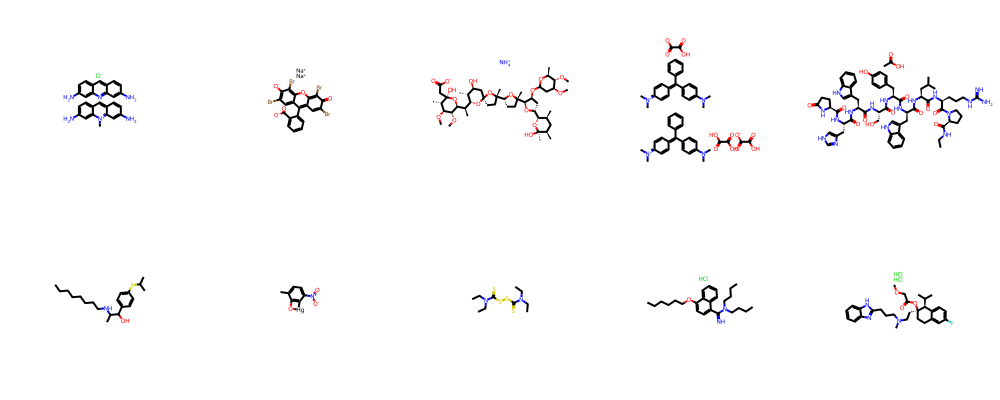

In [223]:
data['mol'] = [Chem.MolFromSmiles(smi) for smi in tqdm(data['SMILES'], desc='Convert SMILES to rdkit mols')]
Draw.MolsToGridImage(data['mol'][:10], molsPerRow=5)

As we can see, some of the "molecules" are really complexes composed of multiple fragments, but once in solution or in the body they will separated. Thus we sanitize them and only consider the largest fragment as our compounds:

In [224]:
def standardize_mol(rd_mol):
    """
    Standardizes an RDKit molecule by performing a series of operations to improve consistency and quality.

    Parameters:
    - rd_mol (Chem.Mol): RDKit molecule to be standardized.

    Returns:
    - Chem.Mol or None: Standardized RDKit molecule if successful, or None if an error occurs during the standardization process.

    The standardization process includes the following steps:
    1. Metal disconnection: Disconnects metal atoms from the molecule.
    2. Normalization: Applies various normalization transformations to the molecule.
    3. Largest fragment selection: Chooses the largest fragment of the molecule.
    4. Uncharging: Removes charges from the molecule.
    5. Removal of molecules without any carbon atoms.
    6. Removal of molecules containing specific salts (e.g., Na, Zn).

    If any step fails or if the resulting molecule does not meet certain criteria, None is returned.
    """
    try:
        charger = rdMolStandardize.Uncharger()
        chooser = rdMolStandardize.LargestFragmentChooser()
        disconnector = rdMolStandardize.MetalDisconnector()
        normalizer = rdMolStandardize.Normalizer()
        carbon = Chem.MolFromSmarts('[#6]')
        salts = Chem.MolFromSmarts('[Na,Zn]')
        rd_mol = disconnector.Disconnect(rd_mol)
        rd_mol = normalizer.normalize(rd_mol)
        rd_mol = chooser.choose(rd_mol)
        rd_mol = charger.uncharge(rd_mol)
        rd_mol = disconnector.Disconnect(rd_mol)
        rd_mol = normalizer.normalize(rd_mol)
        
        # Remove molecules without any carbons
        if len(rd_mol.GetSubstructMatches(carbon)) == 0:
            return None
        # Remove SMILES that still contain salts
        if len(rd_mol.GetSubstructMatches(salts)) > 0:
            return None
        return rd_mol
    except:
        return None
    
# Sanitize molecules
data['mol'] = data['mol'].apply(lambda x : standardize_mol(x))

# Drop all molecules that failed sanitazion
data = data[data.mol.notna()].reset_index(drop=True)

print('Number of sanitized compounds', data.shape[0])

Number of sanitized compounds 12583


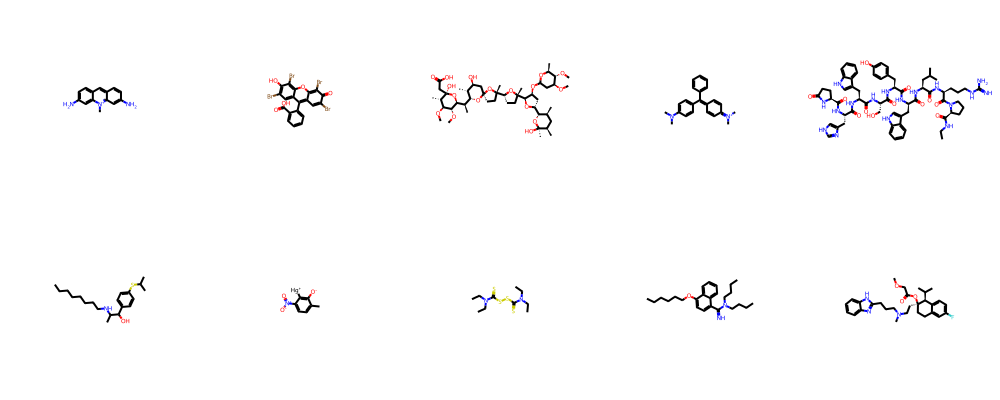

In [225]:
Draw.MolsToGridImage(data['mol'][:10], molsPerRow=5)

<h2 style="color:rgb(0,120,170)">Filtering the dataset</h2>

<h3 style="color:rgb(0,120,170)">ADME and drug-likeness</h3>

In VS, the goal is to predict the potential binding of a compound to a specific target, but for effective drug discovery, it's crucial to assess not only the binding aspect but also the compound's ability to enter the body, navigate barriers, and undergo favorable metabolism and excretion. This assessment, often categorized into the four main steps of **A**bsorption, **D**istribution, **M**etabolism, and **E**xcretion ([ADME](https://en.wikipedia.org/wiki/ADME)).

- The [bioavailability](https://en.wikipedia.org/wiki/Bioavailability) of a compound is an important ADME property, which can be crudely estimated by the [Lipinski's rule of five](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five) (RO5):
    - Molecular weight (MWT) <= 500 Da
    - Number of hydrogen bond acceptors (HBAs) <= 10
    - Number of hydrogen bond donors (HBD) <= 5
    - Calculated LogP (octanol-water coefficient) <= 5

- The quantitative estimate of drug-likeness ([QED](https://www.nature.com/articles/nchem.1243)) is a computational metric designed to assess the overall drug-likeness of a compound, aiding researchers in prioritizing and selecting candidate compounds with favorable pharmacokinetic profiles and increased likelihood of success in development as oral drugs.


Lets take look at number of RO5 violations and QED values for our Tox21 dataset.

In [226]:
data['QED'] = data.mol.apply(lambda mol : QED.qed(mol))
data['RO5_violations'] = data.mol.apply(lambda mol : sum([
    Descriptors.MolWt(mol) > 500,
    Descriptors.NumHAcceptors(mol) > 10,
    Descriptors.NumHDonors(mol) > 5,
    Descriptors.MolLogP(mol) > 5
]))

<Axes: ylabel='Frequency'>

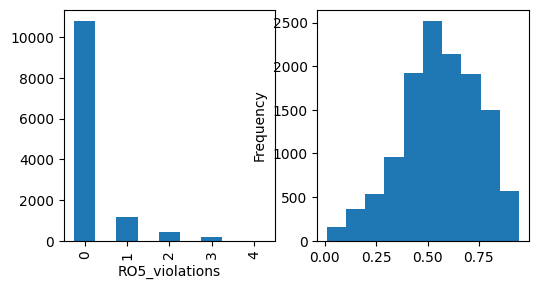

In [227]:
fig, ax = plt.subplots(1,2, figsize=(6,3))
data.RO5_violations.value_counts().plot(kind='bar', ax=ax[0])
data.QED.plot(kind='hist', ax=ax[1])

Let's take a look at molecules that violate all RO5 rules:

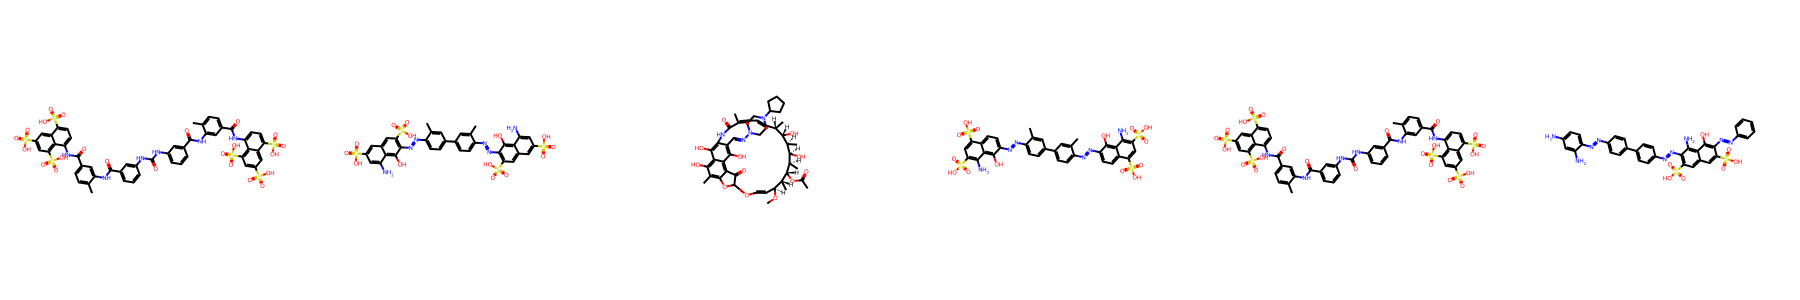

In [228]:
Draw.MolsToGridImage(data[data.RO5_violations == 4].mol, molsPerRow=6, subImgSize=(300,300))

and those with the lowest general drug-likeness:

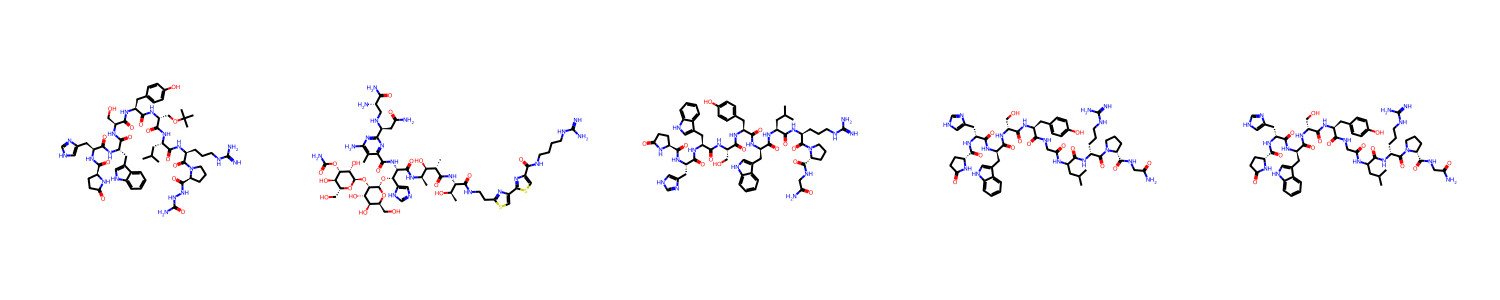

In [229]:
Draw.MolsToGridImage(data.sort_values(by='QED').head().mol.tolist(), molsPerRow=5, subImgSize=(300,300))

Typically this kinds of molecules are discarded from the virtual screening process:

In [230]:
data_filtered = data[ (data.QED > 0.5) & (data.RO5_violations <= 2 ) ]
print('Number of at least somewhat drug-like molecules:', data_filtered.shape[0])

Number of at least somewhat drug-like molecules: 8084


<h3 style="color:rgb(0,120,170)">Unwanted substructures</h3>

Some substructures can be unfavorable, e.g., because they are toxic or reactive, due to unfavorable pharmacokinetic properties, or because they likely interfere with certain assays.


<h4 style="color:rgb(0,120,170)">Pan Assay Inference Compounds</h4>

Pan Assay Interference Compounds ([PAINS](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds)) refer to a set of chemical substructures or motifs commonly found in screening libraries that can lead to false-positive results in high-throughput assays.  

Typically, we want to filter out molecules containing PAINS:

In [231]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

matches = []
labels = []

for mol in data_filtered.mol:
    first_pains = catalog.GetFirstMatch(mol) # Get the 1st matching PAINS 
    if first_pains:
        matches.append(mol)
        labels.append(first_pains.GetDescription())

data_filtered = data_filtered[~data_filtered.mol.isin(matches)]

print('Number of molecules with PAINS:', len(matches))
print('Number of molecules without PAINS:', data_filtered.shape[0])

Number of molecules with PAINS: 414
Number of molecules without PAINS: 7670


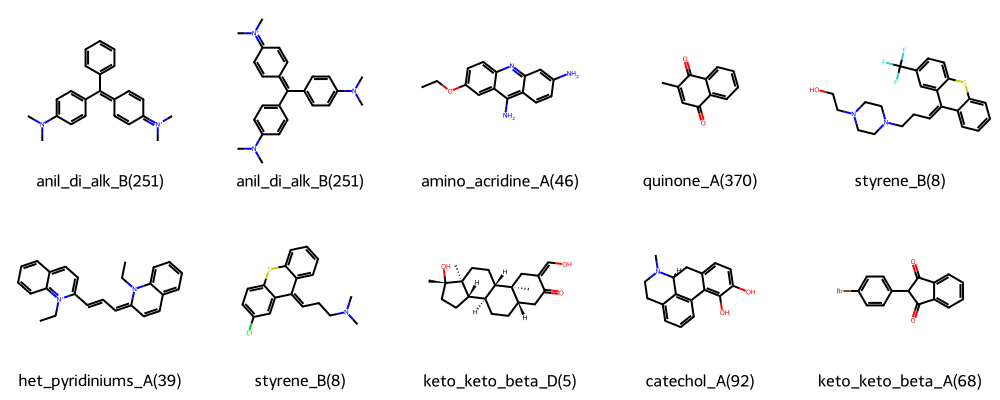

In [232]:
Draw.MolsToGridImage(matches[:10], legends=labels, molsPerRow=5)

<h4 style="color:rgb(0,120,170)">Reactive substructures</h4>

Certain reactive substructures are often filtered out to minimize the risk of unwanted chemical reactivity and improve the likelihood of identifying safe and effective drug candidates. Here are three common reactive substructures that are frequently filtered out:

- Epoxides: `C1OC1`
- α,β-Unsaturated Carbonyls (Michael acceptor): `C=CC(=O)`
- Isocyanates: `N=C=O`


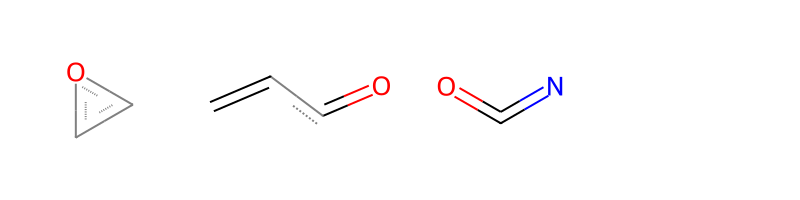

In [233]:
reactive_units = ['C1OC1', 'C=CC(=O)', 'N=C=O']
patterns = [Chem.MolFromSmarts(smarts) for smarts in reactive_units ]
Draw.MolsToGridImage(patterns, molsPerRow=4)

In [234]:
matches = []
for mol in data_filtered.mol:
    if any([mol.HasSubstructMatch(pattern) for pattern in patterns]):
        matches.append(mol)

data_filtered = data_filtered[~data_filtered.mol.isin(matches)].reset_index(drop=True)

print('Number of molecules with reactive subunits:', len(matches))
print('Number of molecules without reactive subunits:', data_filtered.shape[0])

Number of molecules with reactive subunits: 497
Number of molecules without reactive subunits: 7173


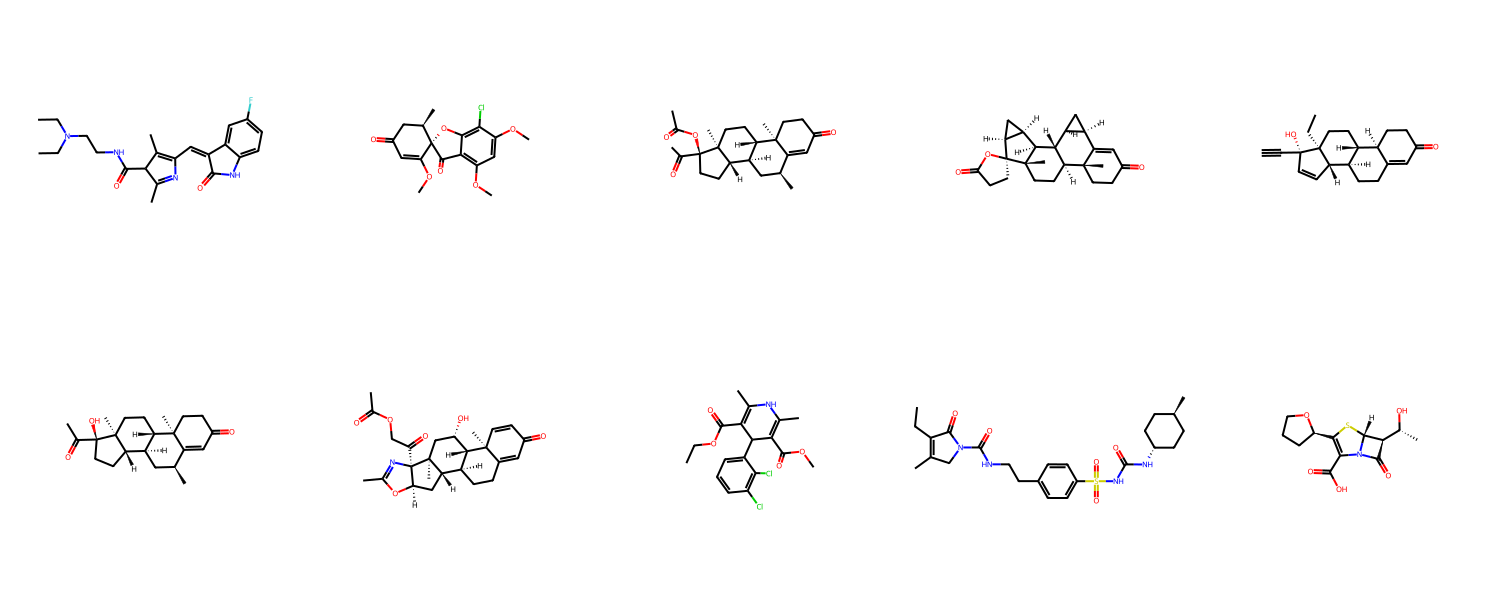

In [235]:
Draw.MolsToGridImage(matches[:10], molsPerRow=5, subImgSize=(300,300))

<h2 style="color:rgb(0,120,170)">Similarity search</h2>

The structure-activity relationship (SAR) approaches are based on the assumption that structurally similar molecules have similar properties and, thus, similar biological activity. In virtual screening, if we have a set of know active molecules, we follow this idea to search for similar molecules in large screening libraries and propose those as potentially new active molecules.

To do so, we need to have a metric that able to assess the similarity of two compounds in a meaninful way. This is not trivial, several approaches have been developed and proposed. A widely, used method is the [Tanimoto similarity](https://en.wikipedia.org/wiki/Jaccard_index) of molecular fingerprints.


First to mimic real world data, we extract a set of known actives for the NR-AR target from our dataset and consider the rest as our screening library:

In [236]:
# "Create" set of know_actives for NR-AR target
data_filtered['known_active'] = (data_filtered['cluster_folds'] == 0) & (data_filtered['NR-AR'] == 1)
print('Number of known actives:', data_filtered[data_filtered.known_active].shape[0])

Number of known actives: 20


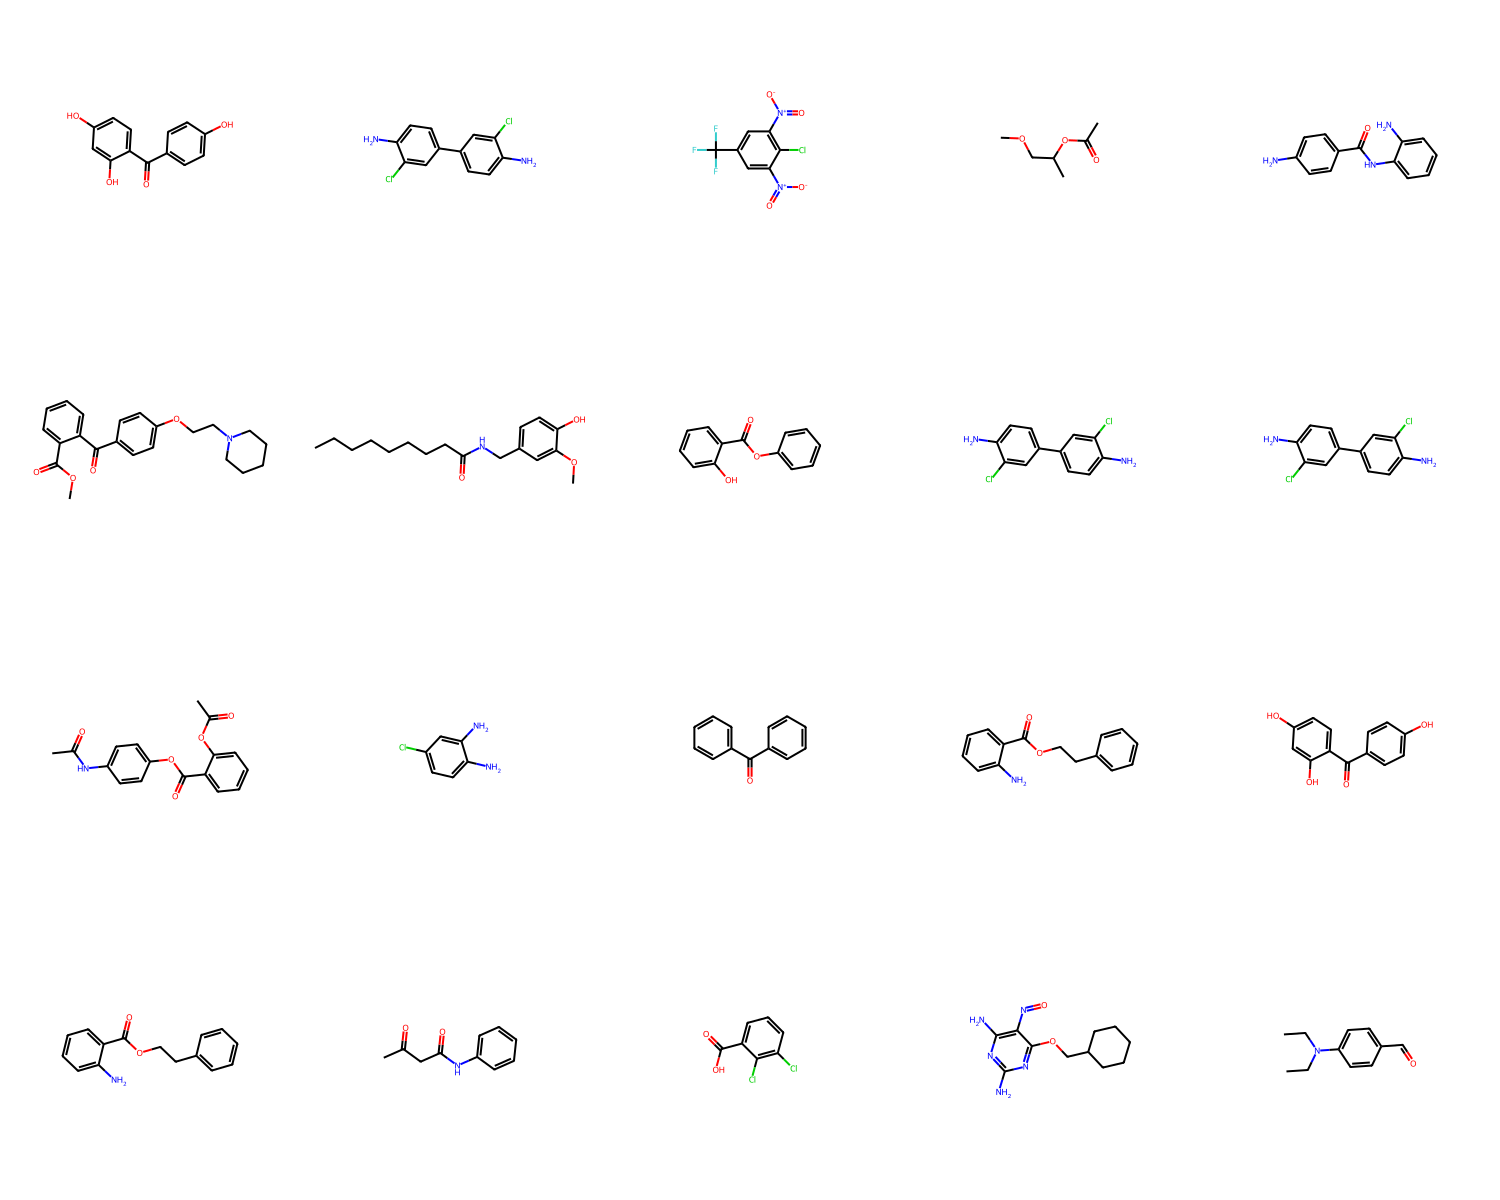

In [237]:
Draw.MolsToGridImage(data_filtered[data_filtered.known_active].mol, molsPerRow=5, subImgSize=(300,300))

Then, we calculate MACCS key fingerprint for all the compounds:

In [238]:
data_filtered['MACCS'] = data.mol.apply(lambda x : rdMolDescriptors.GetMACCSKeysFingerprint(x))

Now, we compute the Tanimoto similarity between the fingerprints of all known actives and our screening library:

In [239]:
# Get the indices for known and unknown
idx_known = data_filtered[data_filtered.known_active].index.tolist()
idx_unknown = data_filtered[~data_filtered.known_active].index.tolist()

# Extract MACCS fingerprints for known and unknown
fps_known = data_filtered.loc[idx_known, 'MACCS'].values
fps_unknown = data_filtered.loc[idx_unknown, 'MACCS'].values

# Initialize similarity matrix
sim_matrix = np.zeros((len(idx_known), len(idx_unknown)))

for i, fp_known in enumerate(fps_known):
    sim_matrix[i,:] = DataStructs.BulkTanimotoSimilarity(fp_known, fps_unknown)

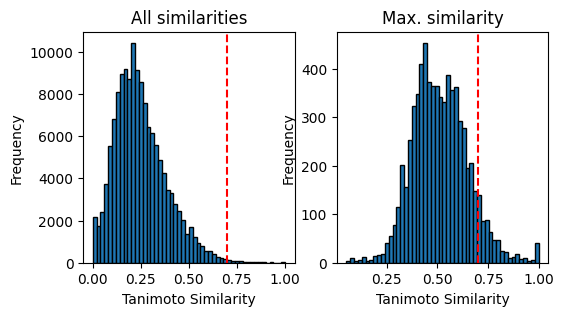

In [240]:
# Plot the histogram of similarity values
fig, ax = plt.subplots(1,2, figsize=(6, 3))
ax[0].hist(sim_matrix.flatten(), bins=50, edgecolor='black')
ax[0].set_xlabel('Tanimoto Similarity')
ax[0].set_ylabel('Frequency')
ax[0].set_title('All similarities')

ax[0].axvline(x=th, color='r', linestyle='--',)

ax[1].hist(sim_matrix.max(axis=0), bins=50, edgecolor='black')
ax[1].set_xlabel('Tanimoto Similarity')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Max. similarity')

ax[1].axvline(x=th, color='r', linestyle='--')

plt.show()


Finally, we select all compounds that have a similarity of higher than 0.7 to at leats one known active (selection of the [threshold](https://greglandrum.github.io/rdkit-blog/posts/2021-05-18-fingerprint-thresholds1.html#maccs) is not trivial and depends on your fingeprint).

In [241]:
th = 0.7
data_filtered.loc[idx_unknown, 'max_sim'] = sim_matrix.max(axis=0)
idx_selected = data_filtered[data_filtered.max_sim > th].index
print('Number of selected compounds:', len(idx_selected))

Number of selected compounds: 599


We can evaluate the effect of selecting compounds based on similarity instead of random with the enrichment factor:

In [242]:
# Fraction of actives in the screening library
f_library = data_filtered.loc[idx_unknown, 'NR-AR'].sum() / len(idx_unknown)

# Fraction of actives in the selected compounds
f_selection = data_filtered.loc[idx_selected, 'NR-AR'].sum() / len(idx_selected)

print(f'Enrichment factor (EF): {f_selection/f_library:.2f}')

Enrichment factor (EF): 1.09


We can visualize the chemical covered by the selected compounds:

In [243]:
# Compute 2D t-SNE embeddings from fingerprints
fps = np.array([np.array(x) for x in data_filtered.MACCS.values])
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(fps)
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
data_filtered_emb = pd.concat([data_filtered, tsne_df], axis=1)

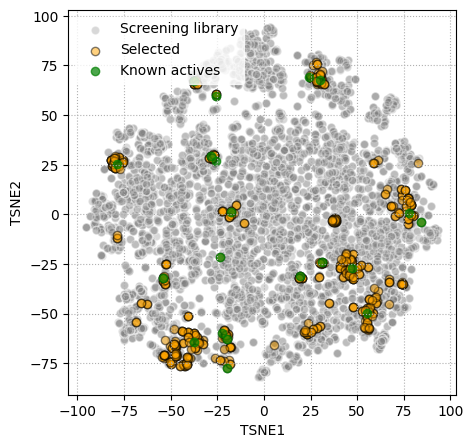

In [244]:
# Visualize the chemical space
fig, ax = plt.subplots(figsize=(5,5))
x, y = data_filtered_emb.iloc[idx_unknown]['TSNE1'], data_filtered_emb.iloc[idx_unknown]['TSNE2'],
ax.scatter(x, y, fc='gray', ec='w', alpha=0.3, label='Screening library')
x, y = data_filtered_emb.iloc[idx_selected]['TSNE1'], data_filtered_emb.iloc[idx_selected]['TSNE2'],
ax.scatter(x, y, fc='orange', ec='k', alpha=0.5, label='Selected')
x, y = data_filtered_emb.iloc[idx_known]['TSNE1'], data_filtered_emb.iloc[idx_known]['TSNE2'],
ax.scatter(x, y, fc='green', alpha=0.7, label='Known actives')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.grid(linestyle=':')
ax.legend(edgecolor='w')

<h2 style="color:rgb(0,120,170)">Molecular diversity</h2>

The molecules picked up by either substructure, similarity or model-based search can exhibit high internal similarity, *i.e.* some the selected compounds only differ slightly form each other. 

In initial stages, of experimental screening of existing libraries, we often would like to cover large areas of chemical space with a limited number of measures. In this case it might not make sense to test two very similar compounds.

Let's use [sphere-exclusion clustering](https://greglandrum.github.io/rdkit-blog/posts/2020-11-18-sphere-exclusion-clustering.html) to pick up a diverse set of compounds:

In [245]:
fps = data_filtered.loc[idx_selected, 'MACCS'].tolist() # Selected compounds from the Similarity search

picker = rdSimDivPickers.LeaderPicker()
centroid_indices =  picker.LazyBitVectorPick(fps, len(fps), 0.3)
idx_centroids = [idx for idx in centroid_indices]
print('Number of cluster centers:', len(idx_centroids))

Number of cluster centers: 60


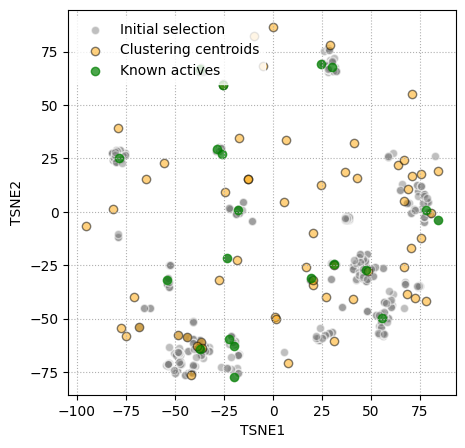

In [246]:
# Visualize the chemical space
fig, ax = plt.subplots(figsize=(5,5))
x, y = data_filtered_emb.iloc[idx_selected]['TSNE1'], data_filtered_emb.iloc[idx_selected]['TSNE2'],
ax.scatter(x, y, fc='gray', ec='w', alpha=0.5, label='Initial selection')
x, y = data_filtered_emb.iloc[idx_centroids]['TSNE1'], data_filtered_emb.iloc[idx_centroids]['TSNE2'],
ax.scatter(x, y, fc='orange', ec='k', alpha=0.5, label='Clustering centroids')
x, y = data_filtered_emb.iloc[idx_known]['TSNE1'], data_filtered_emb.iloc[idx_known]['TSNE2'],
ax.scatter(x, y, fc='g', ec='g', alpha=0.7, label='Known actives')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.grid(linestyle=':')
ax.legend(edgecolor='w')

In [247]:
# Fraction of actives in the screening library
f_library = data_filtered.loc[idx_unknown, 'NR-AR'].sum() / len(idx_unknown)

# Fraction of actives in the selected compounds
f_centroids = data_filtered.loc[idx_centroids, 'NR-AR'].sum() / len(idx_centroids)

print(f'Enrichment factor (EF): {f_centroids/f_library:.2f}')

Enrichment factor (EF): 0.00


<h2 style="color:rgb(0,120,170)">QSAR modeling</h2>

If we have enough, know actives and inactives we can also use machine learning models to predict bioactivity. This the case for the targets in Tox21.

For, our first QSAR model we'll use a Random Forrest Classifier with Morgan fingerprints and evaluate the model with a standard random split.

<h3 style="color:rgb(0,120,170)">Features and labels</h3>


First, let's compute Morgan fingerprints for each molecule:

In [248]:
mfpgen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
fps = np.array([mfpgen.GetFingerprintAsNumPy(mol) for mol in tqdm(data.mol, desc='Compute Morgan fingerprints')])
fps

Compute Morgan fingerprints: 100%|██████████| 12583/12583 [00:01<00:00, 11936.61it/s]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [265]:
y = data[data.columns[1:-4]].values
y

array([[nan, nan, nan, ...,  0., nan, nan],
       [nan, nan, nan, ...,  0., nan, nan],
       [nan, nan, nan, ...,  0., nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0., nan,  0.],
       [ 0.,  0.,  0., ..., nan, nan,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

<h3 style="color:rgb(0,120,170)">Random Split</h3>


In [266]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fps, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10066, 1024), (2517, 1024), (10066, 12), (2517, 12))

<h3 style="color:rgb(0,120,170)">Training models</h3>

Let's train models for each of the 12 tasks in Tox21:

In [267]:
def train_rf(X_train, y_train, X_test):
    """
    Train a random forest model for each task on the supplied training set and return predictions for the test set
    """
    seed = 1234
    n_tasks = y_train.shape[1]
    y_hats_proba = np.empty((X_test.shape[0], n_tasks))
    y_hats_class = np.empty_like(y_hats_proba)
    
    # Train RF per task
    for j in tqdm(range(n_tasks), desc='Train RF per task'):
        rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
        # Mask out unknown samples and NaN values
        idx = (~np.isnan(y_train[:, j]))
        # Train model
        rf_model.fit(X_train[idx], y_train[idx, j])
        # Predict class probabilities (select only values for positiv class with index 1)
        y_hats_proba[:, j] = rf_model.predict_proba(X_test)[:, 1]
        # Predict class 
        y_hats_class[:, j] = rf_model.predict(X_test)
    return y_hats_proba, y_hats_class 

y_hats_proba, y_hats_class = train_rf(X_train, y_train, X_test)

Train RF per task: 100%|██████████| 12/12 [01:23<00:00,  6.96s/it]


We can look at the predicted probabilities and classes. Since the model doesn't know which values of the test set are actually measured and which are missing we get a prediction for each sample.

In [268]:
# probabilistic predictions for test set, 12 tasks
pd.DataFrame(y_hats_proba)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000,0.990000,1.000000,0.425119,1.000000,1.000000,0.00,0.760000,0.000000,0.000,0.080000,0.00
1,0.080,0.000000,0.000000,0.010000,0.010000,0.000000,0.01,0.129167,0.000000,0.024,0.170000,0.00
2,0.030,0.000000,0.010000,0.010000,0.049333,0.000000,0.04,0.020000,0.000000,0.010,0.010000,0.01
3,0.210,0.000000,0.026667,0.020000,0.052500,0.010000,0.00,0.310000,0.130000,0.000,0.280000,0.00
4,0.094,0.000000,0.000000,0.070000,0.050000,0.010000,0.03,0.162667,0.020000,0.100,0.090000,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.100,0.050000,0.035000,0.070000,0.290000,0.020000,0.00,0.046667,0.020000,0.000,0.160000,0.08
2513,0.630,0.010000,0.010000,0.020000,0.464333,0.229333,0.00,0.050000,0.000000,0.000,0.553333,0.05
2514,0.360,0.015556,0.193333,0.008333,0.280000,0.016667,0.01,0.350000,0.270000,0.030,0.366667,0.30
2515,0.196,0.080000,0.032000,0.056667,0.076667,0.093333,0.01,0.275000,0.000000,0.060,0.335000,0.12


In [269]:
# binary predictions for test set, 12 tasks
pd.DataFrame(y_hats_class)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2513,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can also look at the predicted number of samples for each class.

In [270]:
unique, counts = np.unique(y_hats_class, return_counts=True)
dict(zip(unique, counts))

{0.0: 28785, 1.0: 1419}

<h2 style="color:rgb(0,120,170)">Model Evaluation</h2>


To determine the quality of the model we look at several metrics. When calculating metrics we need to remove predictions for missing values as there's no way to measure the quality of these predictions.

<h3 style="color:rgb(0,120,170)">Metrics form binary predictions</h3>

A **confusion matrix** is a table that summarizes the performance of a classification algorithm by displaying the counts of true positive, true negative, false positive, and false negative predictions, providing a detailed insight into the model's accuracy and error rates. 

In [271]:
def plot_confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap for visualization
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred. Inactive", "Pred. Active"],
                yticklabels=["True Inactive", "True Active"])

    plt.title('Confusion Matrix')
    plt.show()  

Let's look at the confusion matrix for the 1st task:

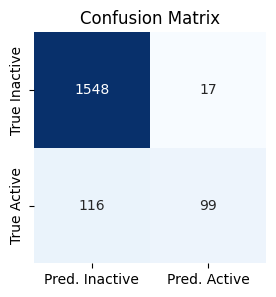

In [272]:
task = 0
idx = (~np.isnan(y_test[:, task]))
plot_confusion_matrix(y_test[idx,task], y_hats_class[idx,task])

A large variety of metrics can be computed from the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Here is a list of the some of the metrics used ones in the fields:
- The **accuracy** is the ratio of correctly predicted instances to the total instances, calculated as $\frac{TP + TN}{TP + TN + FP + FN}$. 

- The **precision** is the ratio $\frac{TP}{TP + FP}$ where TP is the number of true positives and FP the number of false positives. Precision is intuitively the ability of the classifier to not label negative samples as positive.

- The **recall** (sensitivity) is the ratio $\frac{TP}{TP + FN}$ where TP is the number of true positives and FN the number of false negatives. Recall is intuitively the ability of the classifier to find all the positive samples.

- The **F1-score** can be interpreted as a weighted harmonic mean of precision and recall.

- The **balanced accuracy** is the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), calculated as $\frac{\mathrm{Sensitivity} + \mathrm{Specificity}}{2}$.

- The **MCC (Matthews correlation coefficient)** is a measure of the quality of binary classifications, considering all four elements of the confusion matrix.

Closer to 1, the better for all these metrics.

In [273]:
def classification_metrics(y_test, y_hats_class):

    # List of metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Balanced Accuracy', 'MCC']

    # Initialize a DataFrame
    result_df = pd.DataFrame(index=range(y_test.shape[1]), columns=metrics)

    # Calculate metrics for each target
    for j in range(y_test.shape[1]):
        y_true, y_pred = y_test[:, j], y_hats_class[:, j]
        idx = (~np.isnan(y_true))
        y_true, y_pred = y_true[idx], y_pred[idx]
                
        result_df.at[j, 'Accuracy'] = accuracy_score(y_true, y_pred)
        result_df.at[j, 'Precision'] = precision_score(y_true, y_pred)
        result_df.at[j, 'Recall'] = recall_score(y_true, y_pred)
        result_df.at[j, 'F1-Score'] = f1_score(y_true, y_pred)
        result_df.at[j, 'Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
        result_df.at[j, 'MCC'] = matthews_corrcoef(y_true, y_pred)

    return result_df

In [274]:
df_stats = classification_metrics(y_test, y_hats_class)
df_stats

,Accuracy,Precision,Recall,F1-Score,Balanced Accuracy,MCC
0,0.925281,0.853448,0.460465,0.598187,0.724801,0.593608
1,0.980703,0.93617,0.55,0.692913,0.774227,0.709538
2,0.987027,0.906977,0.661017,0.764706,0.829392,0.768251
3,0.964775,0.674419,0.42029,0.517857,0.705364,0.515728
4,0.898284,0.711538,0.352381,0.471338,0.665642,0.454131
5,0.971129,0.790323,0.538462,0.640523,0.765648,0.638582
6,0.975978,0.904762,0.316667,0.469136,0.657755,0.527399
7,0.891013,0.798246,0.380753,0.515581,0.68173,0.50315
8,0.965938,0.8,0.318182,0.455285,0.657228,0.491731
9,0.956863,0.925926,0.25,0.393701,0.624407,0.468794


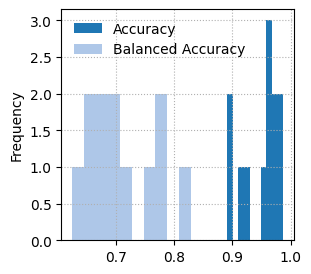

In [276]:
df_stats['Accuracy'].plot(kind='hist',figsize=(3,3), legend=True)
df_stats['Balanced Accuracy'].plot(kind='hist',figsize=(3,3), legend=True)
plt.legend(frameon=False)
plt.grid(linestyle=':')

<h3 style="color:rgb(0,120,170)">Metrics from probalistic predictions</h3>

[ROC (Receiver Operating Characteristic)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a graphical representation illustrating the trade-off between sensitivity and specificity for a binary classification model, providing a visual summary of its performance across different decision thresholds.

The area under the ROC curve (AUC) is a metric used to assess the performance of a binary classification model by measuring the area under the ROC curve, which plots the true positive rate against the false positive rate at various classification thresholds. A higher ROC AUC score indicates better discrimination ability of the model in distinguishing between positive and negative instances.

Next, we take a look at the ROC curves for each task and compute the AUC.


In [277]:
sns.set_palette("tab20",plt.cm.tab20c.N )

def plot_roc_curves(target, prediction):
    fig, ax = plt.subplots(figsize=(5, 5))
    aucs = [] 
    for j in range(target.shape[1]):
        y_pred = prediction[:, j]
        y_true = target[:, j]
        # Mask out unknown samples and NaN values
        idx = (~np.isnan(y_true))
        # Calculate ROC and AUC
        fpr, tpr, thresholds = roc_curve(y_true[idx], y_pred[idx])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, label=f'{j} (AUC = {roc_auc:.2f})')

    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve (Mean AUC = {np.mean(aucs):.2f})')
    ax.legend(loc="lower right", edgecolor='w')
    ax.grid(linestyle=':')
    ax.plot([0,1], [0,1], 'k--')
    
    plt.show()

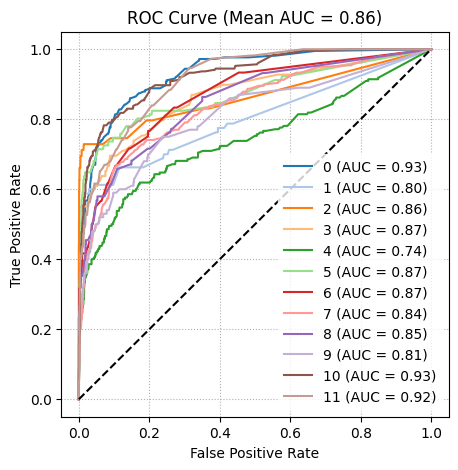

In [278]:
plot_roc_curves(y_test, y_hats_proba)

<h2 style="color:rgb(0,120,170)">Train model with Scaffold-split</h2>

The previous model was trained with samples randomly assigned to the training and test sets. However, if we want to know how well our model generalizes to future data it might be a better idea to assign the training and test samples based on structural similarity. If we cluster the samples and assign all samples of some clusters to the training set and all samples of the other clusters to the test set we avoid that very similar samples are in the training and test sets.

The clustering could be done based on similarity of molecular fingerprints (see Molecular diversity section), but here we'll use Bemis-Murcko scaffolds:

Number of unique scaffolds: 1519


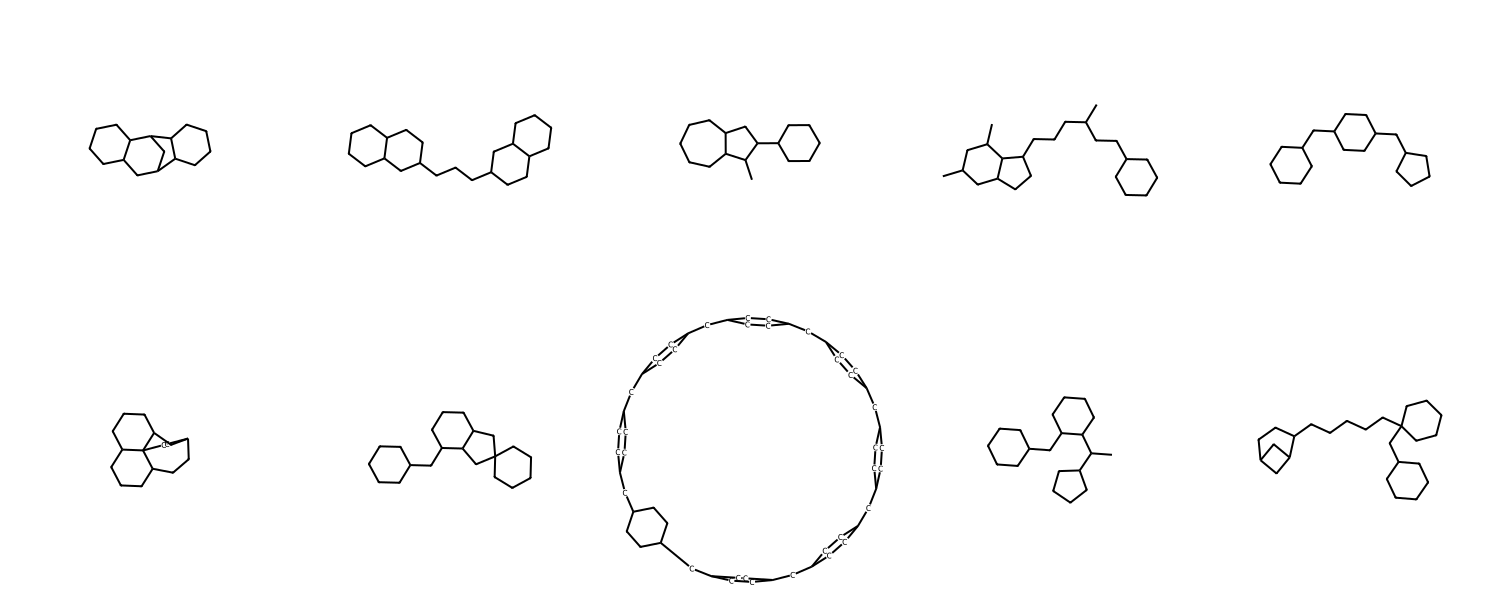

In [279]:
# Add Murcko scaffolds to the dataframe
data['scaffold'] = [MurckoScaffold.MakeScaffoldGeneric(MurckoScaffold.GetScaffoldForMol(mol)) for mol in data.mol]
data['scaffold_smiles'] = [Chem.MolToSmiles(scaffold) for scaffold in data.scaffold]
print('Number of unique scaffolds:', data.scaffold_smiles.nunique())

# Draw the 10 random scaffolds
random_scaffolds = [Chem.MolFromSmiles(smi) for smi in np.random.choice(data.scaffold_smiles.unique(), 10)]
Draw.MolsToGridImage(random_scaffolds, molsPerRow=5, subImgSize=(300,300))


Starting from the smallest clusters we assign clusters to the test set until it includes 20% of the data:

In [287]:
test_idx = []
for scaffold in data.scaffold_smiles.unique():
    idx = data[data.scaffold_smiles == scaffold].index
    test_idx.extend(idx)
    if len(test_idx) / data.shape[0] > 0.2:
        break

test_idx = np.array(test_idx)
train_idx = np.setdiff1d(data.index.values, test_idx)
X_train, X_test = fps[train_idx,:], fps[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9509, 1024), (3074, 1024), (9509, 12), (3074, 12))

In [288]:
y_hats_proba, y_hats_class = train_rf(X_train, y_train, X_test)

Train RF per task: 100%|██████████| 12/12 [01:03<00:00,  5.30s/it]


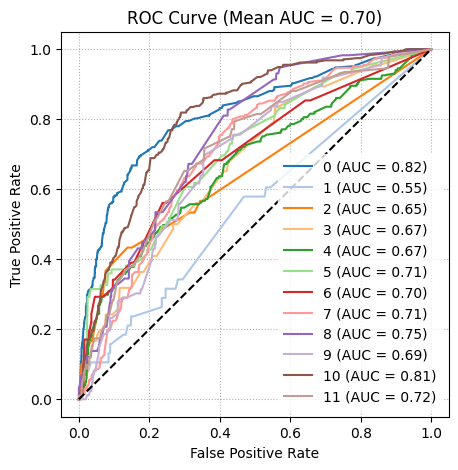

In [289]:
plot_roc_curves(y_test, y_hats_proba)

<h1 style="color:rgb(0,120,170)">Further info/examples</h1>

- `03_graph_neural_networks.ipynb` (Bonus demo - not covered in the UE)
- [Teachopencadd T002: Compound ADME](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T002_compound_adme)
- [Teachopencadd T003: Unwanted substructures](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T003_compound_unwanted_substructures)
- [Teachopencadd T004: Compound similarity](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T004_compound_similarity)
- [Teachopencadd T005: Compound clustering](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T005_compound_clustering)
- [Teachopencadd T007: Ligand-based screening: machine learning](https://projects.volkamerlab.org/teachopencadd/talktorials/T007_compound_activity_machine_learning.html)
- [Teachopencadd T009: Ligand-based pharmacophores](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T009_compound_ensemble_pharmacophores)
- [Sphere exclusion clustering with the RDKit](https://greglandrum.github.io/rdkit-blog/posts/2020-11-18-sphere-exclusion-clustering.html)